# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Clip Video to Image

In [3]:
import os
from moviepy.editor import *
def extract_frames(movie, times, imgdir):
    clip = VideoFileClip(movie)
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)
movie = "test_videos/bonus1.mp4"
imgdir = 'bonus/'
times = 5,10,15,20,25,30
extract_frames(movie, times, imgdir)

## Ideas for Lane Detection Pipeline

## Helper Functions

檔案讀取

In [4]:
def file_read(folder_path):
    # 列出資料夾內的所有檔案
    files = os.listdir(folder_path)
    # 儲存圖片和對應名稱的清單
    images = []
    names = []
    # 逐一讀取檔案並儲存圖片和名稱
    for file_name in files:
        # 檔案的完整路徑
        file_path = os.path.join(folder_path, file_name)
        
        # 讀取圖片檔案
        image = mpimg.imread(file_path)
        
        # 將圖片和名稱加入清單
        images.append(image)
        names.append(file_name)
    
    return images, names

色彩空間轉換

In [5]:
def convert_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

顏色偵測

In [6]:
import math

# image is expected be in RGB color space
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.array([200, 200, 200])
    upper = np.array([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.array([185, 185,   0])
    upper = np.array([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

def select_hls_white_yellow(image):
    converted = convert_hls(image)
   # white color mask
    lower = np.array([  0, 200,   0])
    upper = np.array([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.array([ 20,   0, 100])
    upper = np.array([ 60, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked


灰階轉換

In [7]:

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    


高斯模糊

In [8]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


邊緣偵測

In [9]:

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)


ROI遮罩

In [10]:

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


Hough Transform

In [11]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines


平均斜率和截距

In [12]:

# 計算平均車道線邊緣的平均斜率和截距
def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # 因為y軸由上至下，所以左車道線斜率為負
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    # 以線段長度作為權重作加權平均，計算平均斜率和截距    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)


斜率轉換端點

In [13]:
def make_line_points(y1, y2, line):
    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))


車道線計算

In [14]:

def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle

    left_line  = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    
    return left_line, right_line


繪製車道線

In [15]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    line_image = np.zeros_like(img)
    for line in lines:
        if line is not None:
            # 擷取線的端點
            pt1, pt2 = line
            cv2.line(line_image, pt1, pt2, color, thickness)
    return line_image

圖像重疊

In [16]:

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

圖像輸出

In [17]:
def image_display(images, names, num_cols, fig_size = (16,8),cmap =None):
    # 設定圖像的大小
    plt.figure(figsize=fig_size)
    # 計算行數
    num_rows = -(-len(images) // num_cols)  # 取上整除
    # 逐一顯示圖片
    for i in range(len(images)):
        # 設定 subplot
        plt.subplot(num_rows, num_cols, i + 1)
        cmap = 'gray' if len(images[i].shape)==2 else cmap
        plt.imshow(images[i],cmap=cmap)
        plt.title(names[i])  # 使用儲存的名稱設定標題

    plt.tight_layout()  # 自動調整子圖之間的間距
    plt.show()

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [18]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'YellowUnderShade.jpg',
 'YellowUnderShade2.jpg',
 'YellowWhite.jpg',
 'YellowWhite2.jpg']

讀取檔案

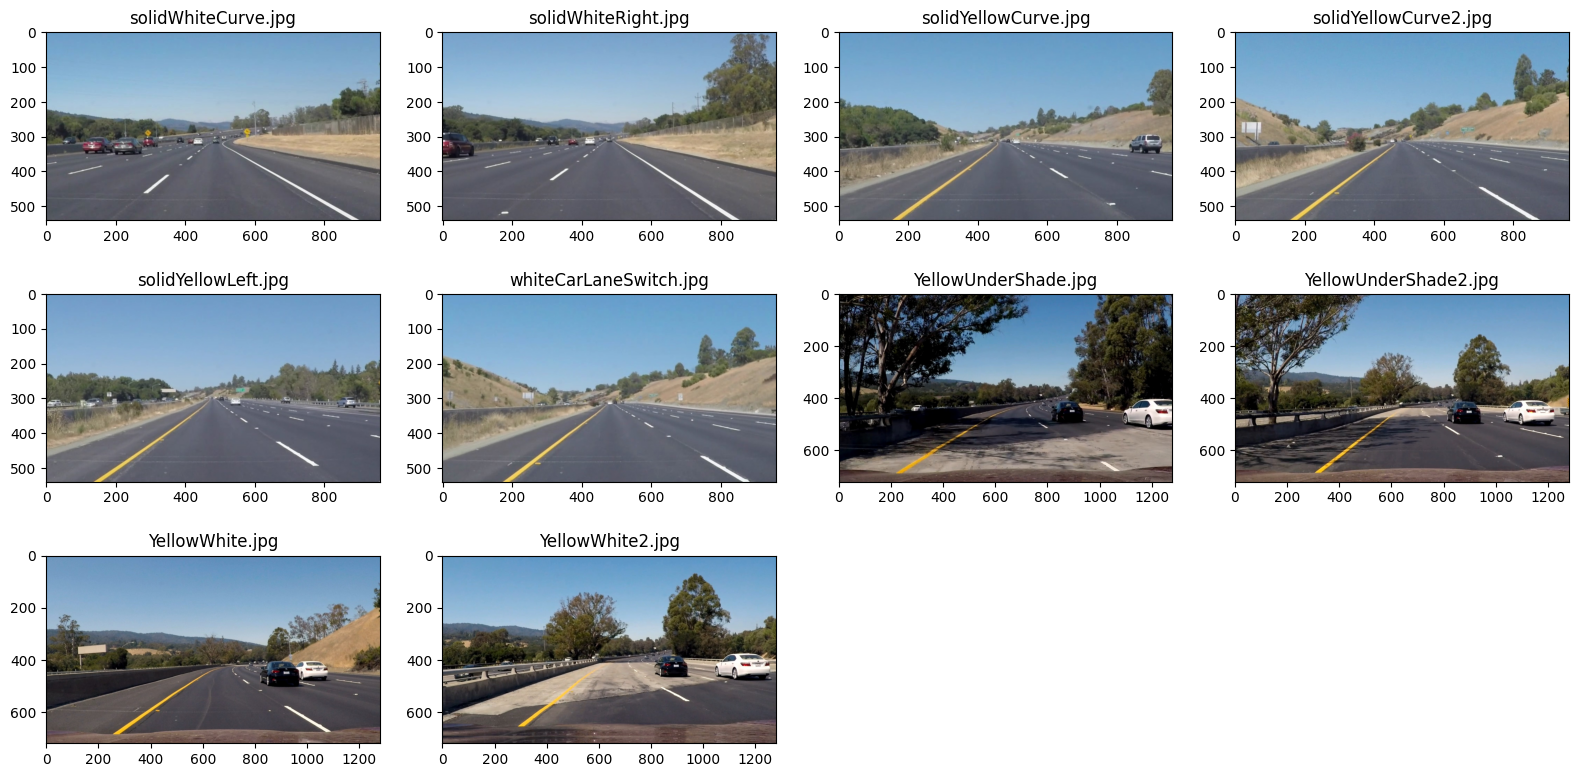

In [20]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
# 指定資料夾路徑
folder_path = 'test_images/'
images, names = file_read(folder_path)
image_display(images,names,4)


色彩空間轉換

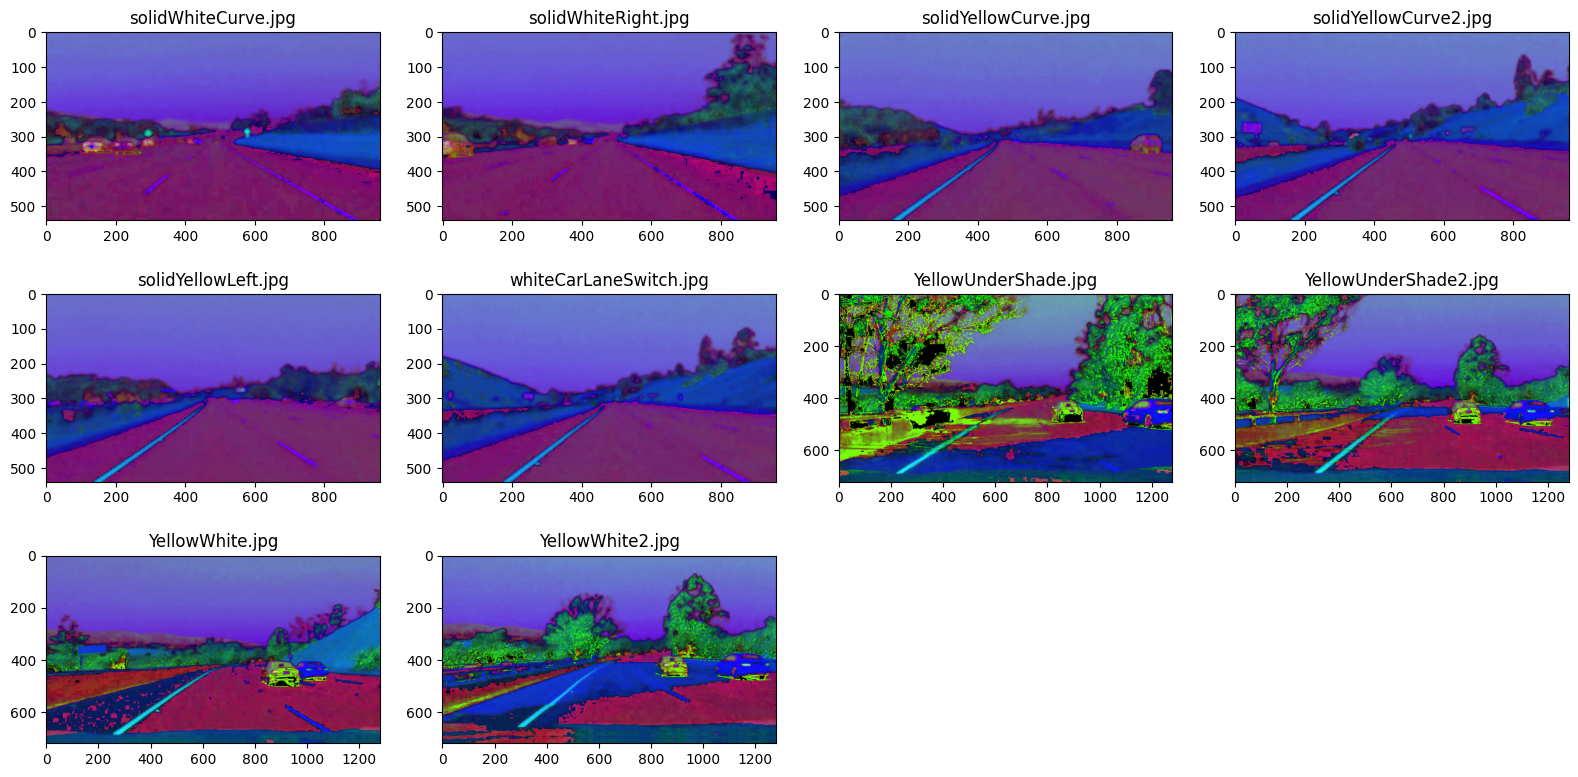

In [21]:
hsv_imgs = []
hls_imgs = []
for image in images:
    hsv_imgs.append(convert_hsv(image))
    hls_imgs.append(convert_hls(image))
image_display(hsv_imgs,names,4)


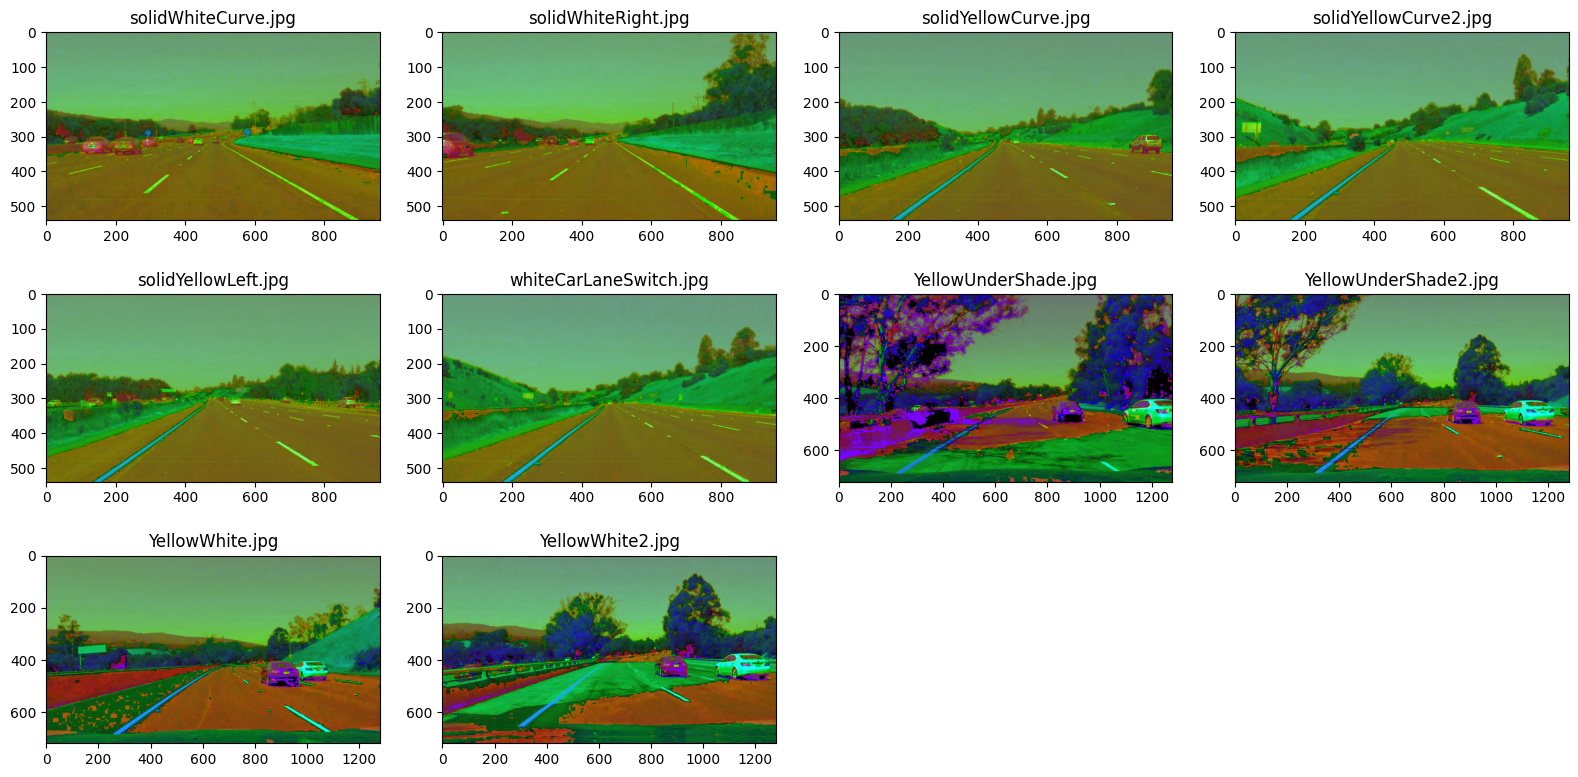

In [23]:
image_display(hls_imgs,names,4)

顏色偵測

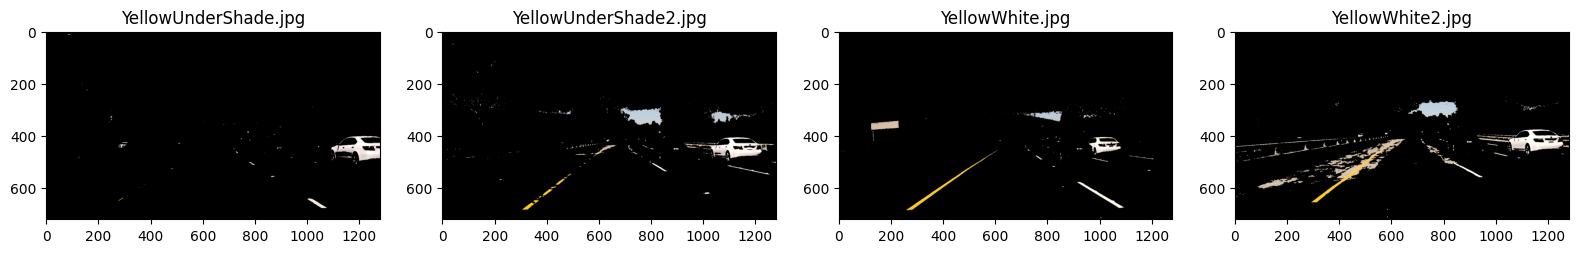

In [24]:
color_masks = []
for image in images:
    color_masks.append(select_rgb_white_yellow(image))

image_display(color_masks[6:10],names[6:10], 4)

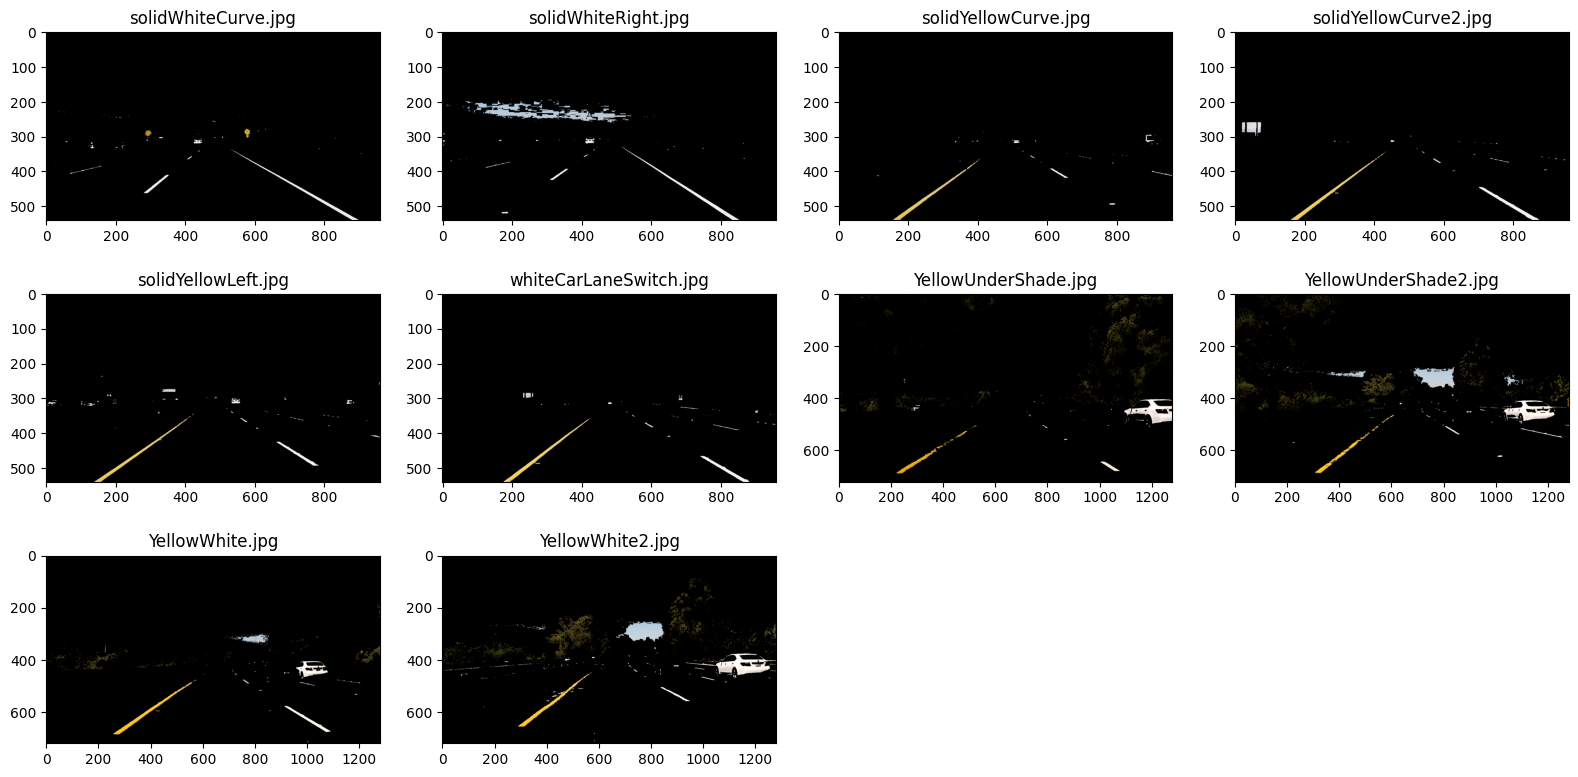

In [25]:
hls_masks = []
for image in images:
    hls_masks.append(select_hls_white_yellow(image))

image_display(hls_masks,names, 4)

灰階轉換

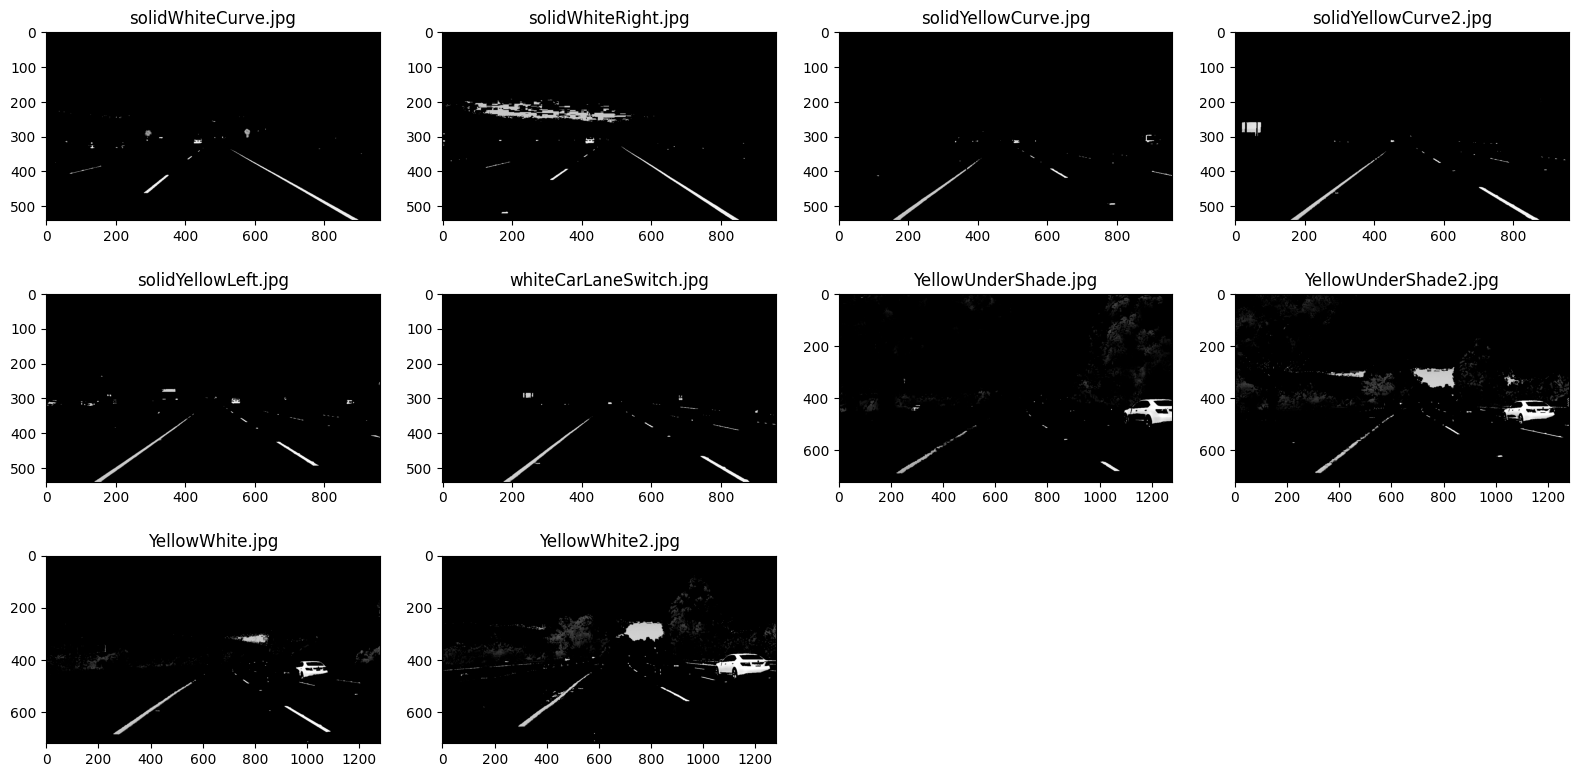

In [26]:
# Gray scale
gray_imgs = []
# 逐一顯示圖片
for image in hls_masks:
    gray_imgs.append(grayscale(image))

image_display(gray_imgs,names,4)

圖像模糊和邊緣偵測

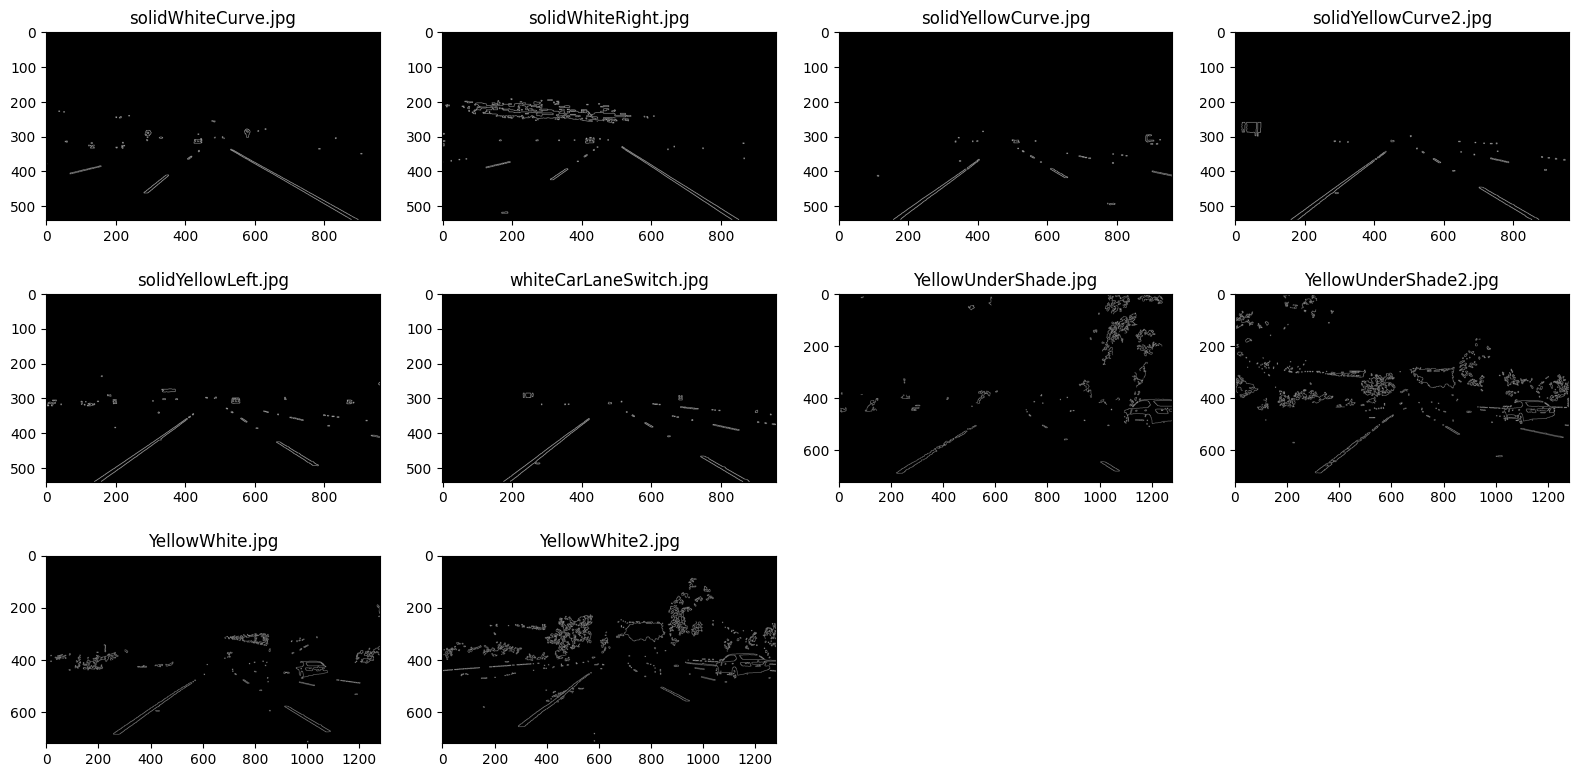

In [27]:
# Canny scale
edge_imgs = []
for image in gray_imgs:
    edge_imgs.append(canny(gaussian_blur(image,5),40,120))

image_display(edge_imgs,names,4)

ROI遮罩

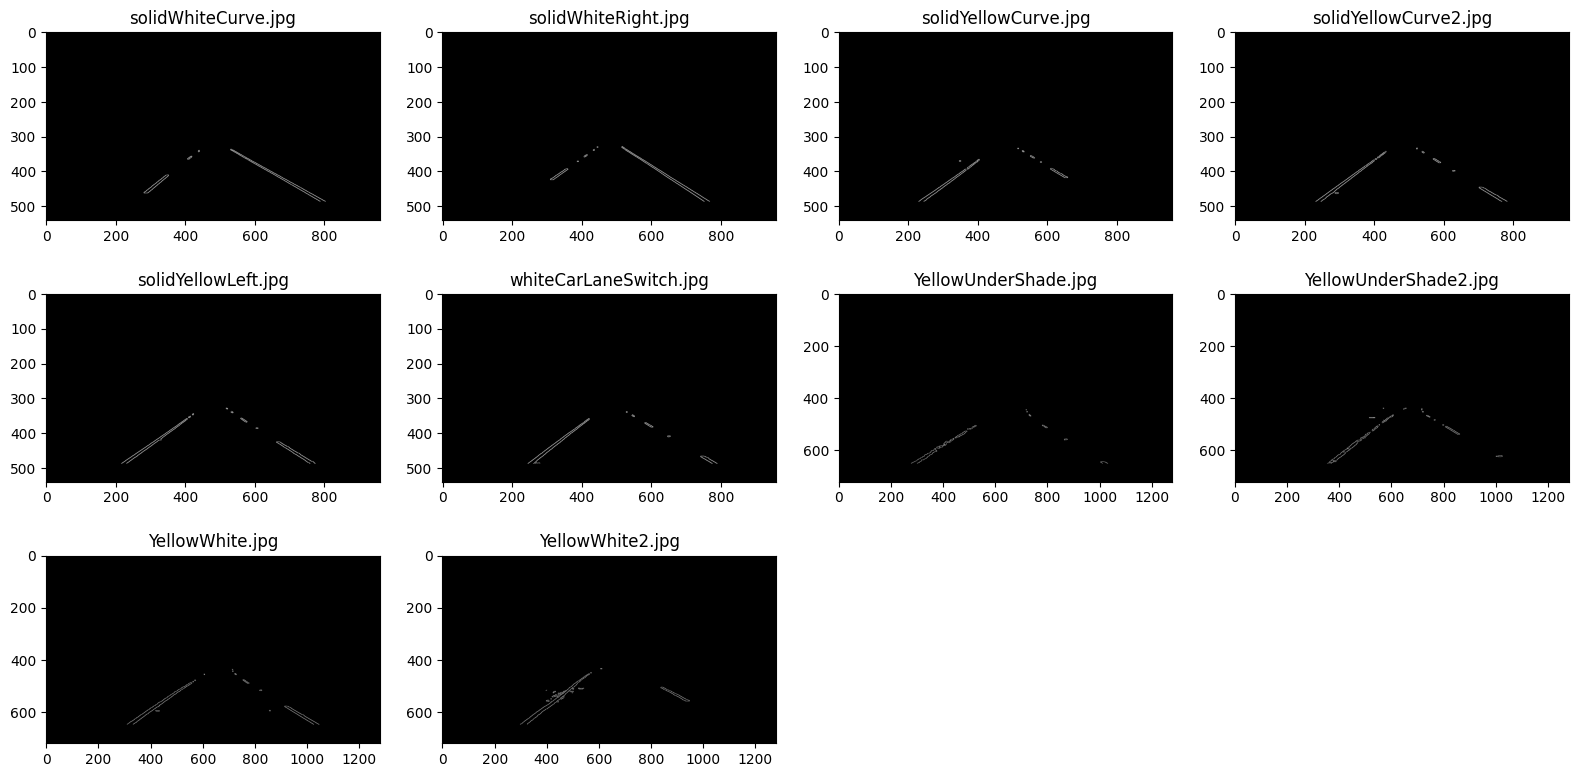

In [28]:
roi_images = []
for image in edge_imgs:
    # ROI mask
    xsize, ysize = image.shape[1], image.shape[0]
    vertices = [np.array([[xsize*0.1, ysize*0.9], [xsize*0.9, ysize*0.9], [xsize*0.55, ysize*0.6], [xsize*0.45, ysize*0.6]], dtype=np.int32)]
    roi_images.append(region_of_interest(image,vertices))

image_display(roi_images,names,4)

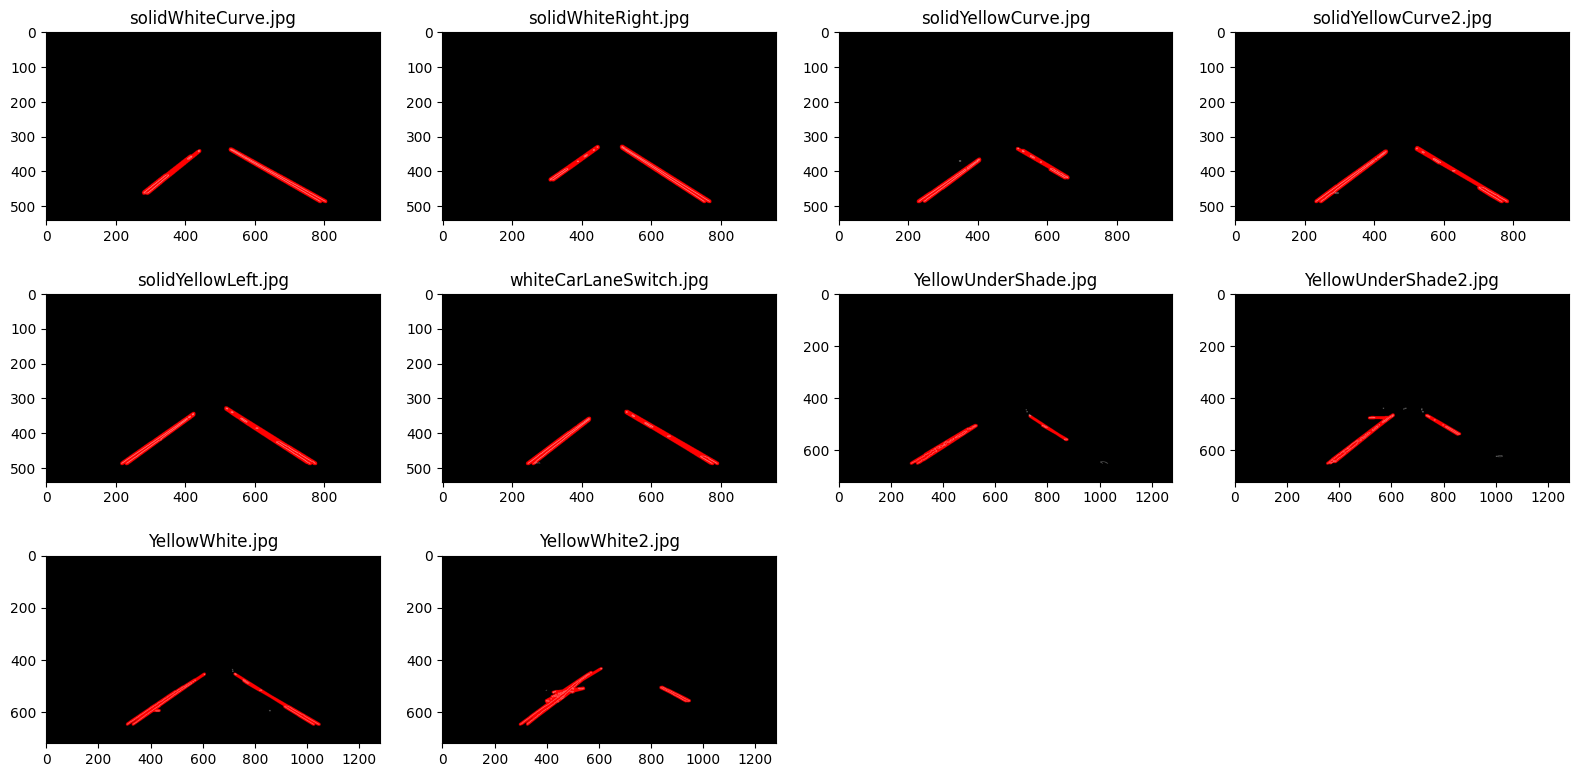

In [29]:
# 畫出偵測到的線段
hough_imgs = []
for img in roi_images:
    lines = cv2.HoughLinesP(img, 1, np.pi/180, 20,np.array([]), 20, 100)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # hough_imgs.append(draw_lines(line_img, lines))
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((img, img, img)) 

    # Draw the lines on the edge image
    hough_imgs.append( cv2.addWeighted(color_edges, 0.8, line_img, 1, 0) )

image_display(hough_imgs,names,4)

繪製車道線

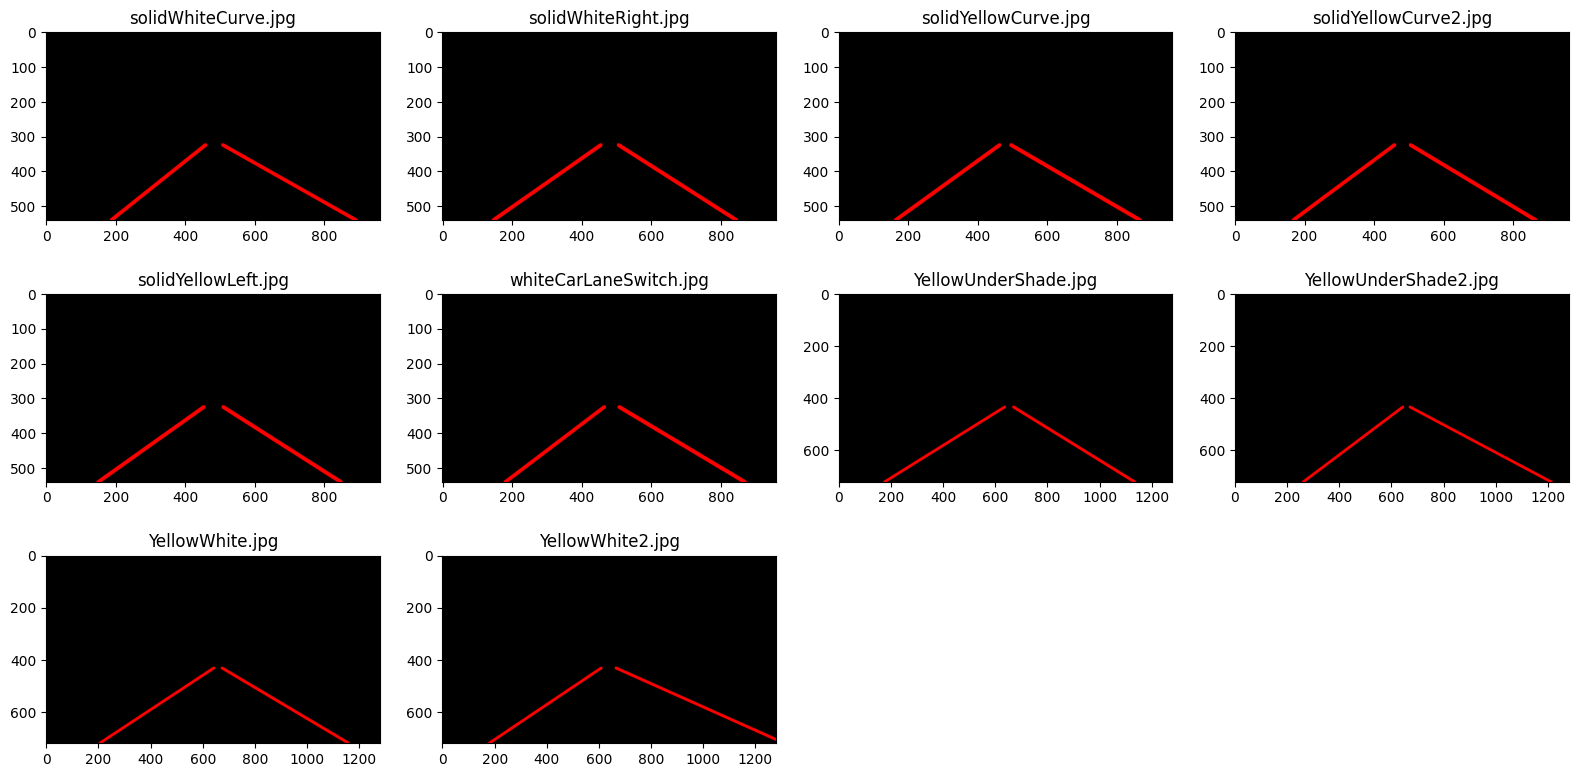

In [30]:
lane_images = []
for img, roi in zip(images,roi_images):
    # 計算直線線段
    lines = hough_lines(roi, 1, np.pi/180, 20, 20, 100)
    # 計算左右車道線並繪製
    lane_image =  draw_lines(img,lane_lines(img,lines))
    lane_images.append(lane_image)
image_display(lane_images,names,4)

合併原圖和車道線

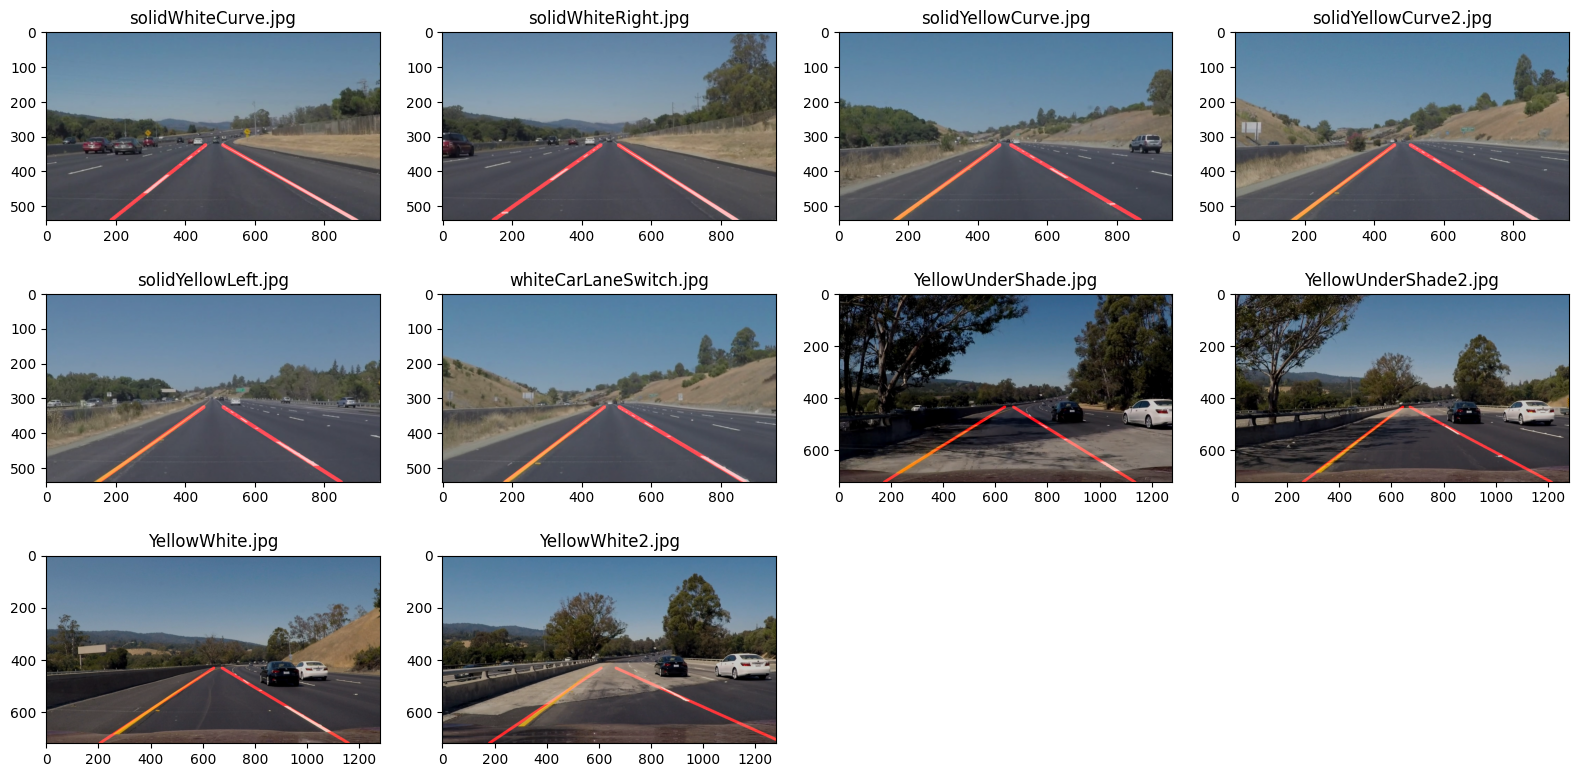

In [31]:
# final image
final_images = []
for image, lane in zip(images,lane_images):
    final_images.append(weighted_img(lane,image))
image_display(final_images,names,4)

## Build a Lane Finding Pipeline



初次Pipeline測試

In [33]:
class LaneDetector:
    def __init__(self):
        # 儲存繪製的車道線
        self.lane_line = []
        # 儲存設定的ROI區域
        self.vertices = []
    
    def process(self, image):
        xsize, ysize = image.shape[1], image.shape[0]
        self.vertices = [np.array([[0, ysize], [xsize, ysize], [xsize*0.55, ysize*0.6], [xsize*0.45, ysize*0.6]], dtype=np.int32)]
        mask = select_rgb_white_yellow(image)
        gray = grayscale(mask)
        blur = gaussian_blur(gray, 15)
        edge = canny(blur,40,120)
        roi = region_of_interest(edge,self.vertices)
        # 計算所有直線線段
        lines = hough_lines(roi, 1, np.pi/180, 20, 20, 100)
        # 計算左右車道線並繪製
        lane_line =  draw_lines(image,lane_lines(image,lines))
        return weighted_img(lane_line,image)


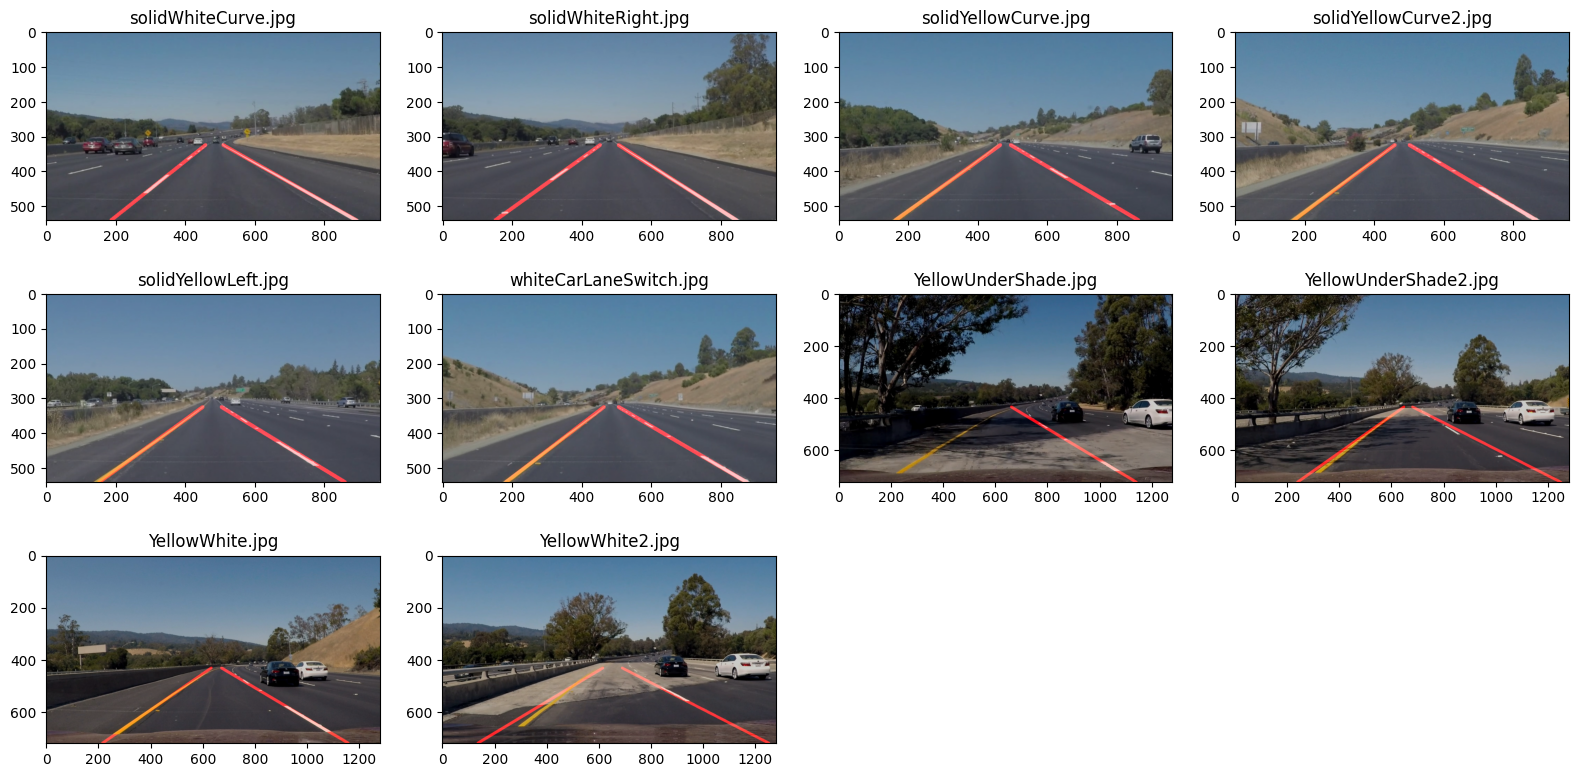

In [34]:
detector = LaneDetector()
output = []
for image in images:
    output.append(detector.process(image))
image_display(output,names,4)

修正後的Pipeline測試

In [38]:
from collections import deque
class LaneDetector:
    def __init__(self,queue_length):
        self.QUEUE_LENGTH = queue_length
        self.lane_line_queue = deque(maxlen=self.QUEUE_LENGTH)
        self.vertices = []
    
    def process(self, image):
        xsize, ysize = image.shape[1], image.shape[0]
        self.vertices = [np.array([[xsize*0.1, ysize*0.9], [xsize*0.9, ysize*0.9], [xsize*0.55, ysize*0.6], [xsize*0.45, ysize*0.6]], dtype=np.int32)]
        mask = select_hls_white_yellow(image)
        gray = grayscale(mask)
        blur = gaussian_blur(gray, 15)
        edge = canny(blur,40,120)
        roi = region_of_interest(edge,self.vertices)
        # 計算直線線段
        lines = hough_lines(roi, 1, np.pi/180, 20, 20, 100)

        lane_line_points = lane_lines(image, lines)

        def mean_line(line_points, lines_queue):
            if line_points is not None:
                # 傳入計算出的車道線端點
                lines_queue.append(line_points)

            if len(lines_queue)>0:
                # 計算平均
                mean = np.mean(lines_queue, axis=0, dtype=np.int32)
                mean = tuple(map(tuple, mean)) # make sure it's tuples not numpy array for cv2.line to work
            return mean

        mean_lane_lines  = mean_line(lane_line_points,  self.lane_line_queue)
        

        # 計算左右車道線並繪製
        lane_line =  draw_lines(image,mean_lane_lines)
        return weighted_img(lane_line,image)


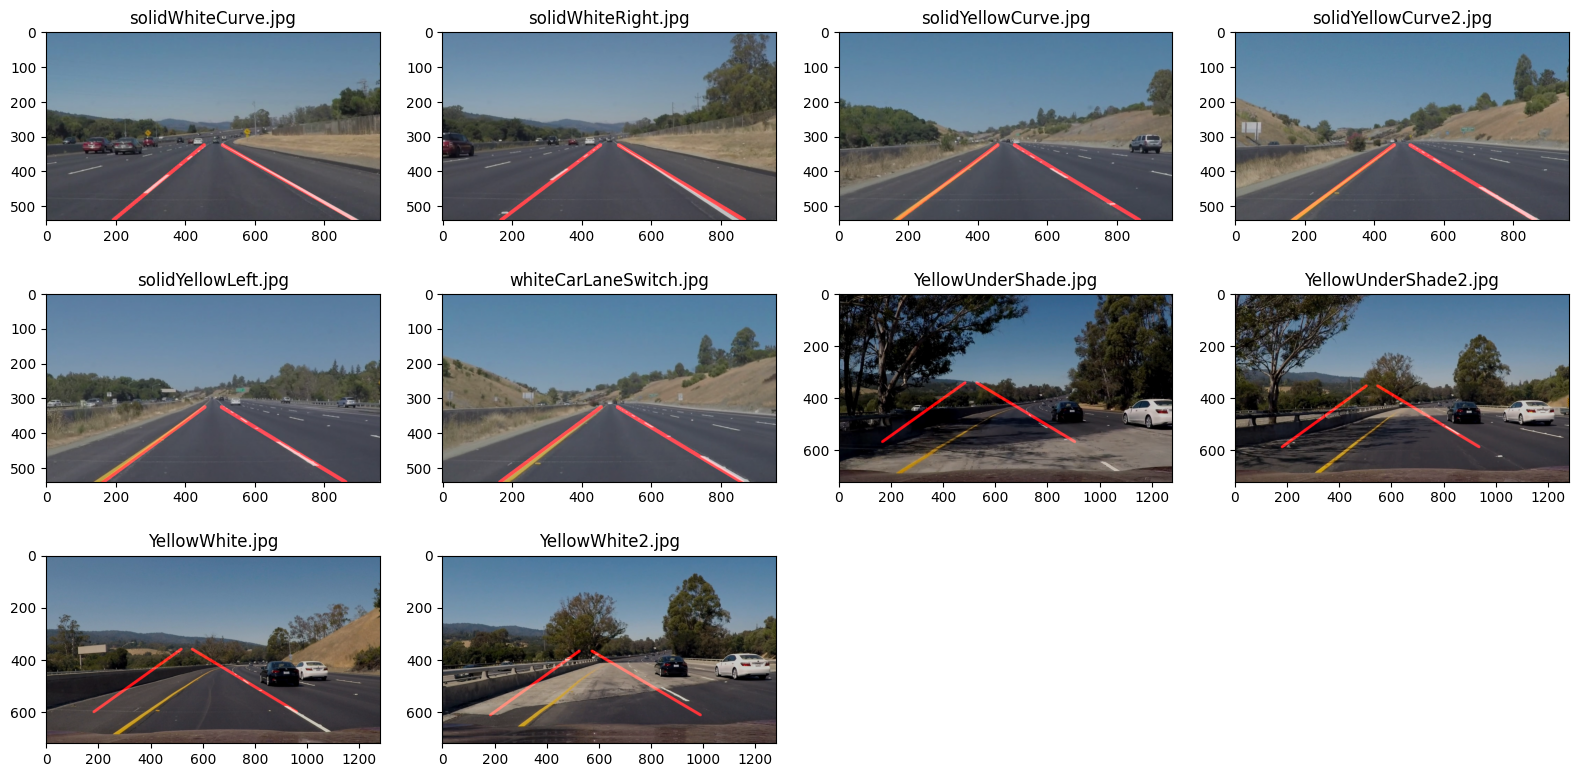

In [39]:
detector = LaneDetector(20)
output = []
for image in images:
    output.append(detector.process(image))
image_display(output,names,4)

## Test on Videos


In [40]:
from moviepy.editor import VideoFileClip

def process_video(video_input, video_output):
    # 初次測試
    # detector = LaneDetector()
    
    # 最終測試
    detector = LaneDetector(20)

    # 讀取輸入影片並獲取其幀率
    clip = VideoFileClip(os.path.join('test_videos', video_input))
    input_fps = clip.fps

    # 將輸入影片的幀率用於輸出影片
    processed = clip.fl_image(detector.process)
    processed.write_videofile(
        os.path.join('test_videos_output', video_output),
        fps=input_fps,  # 使用輸入影片的幀率
        audio=False
    )


In [41]:
%time process_video('solidWhiteRight.mp4', 'solidWhiteRight_final.mp4')   

Moviepy - Building video test_videos_output\solidWhiteRight_final.mp4.
Moviepy - Writing video test_videos_output\solidWhiteRight_final.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output\solidWhiteRight_final.mp4
CPU times: total: 1.47 s
Wall time: 3.98 s


In [42]:
%time process_video('solidYellowLeft.mp4', 'solidYellowLeft_final.mp4')   

Moviepy - Building video test_videos_output\solidYellowLeft_final.mp4.
Moviepy - Writing video test_videos_output\solidYellowLeft_final.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output\solidYellowLeft_final.mp4
CPU times: total: 5.36 s
Wall time: 10.3 s


In [43]:
%time process_video('challenge.mp4', 'challenge_fianl.mp4')   

Moviepy - Building video test_videos_output\challenge_fianl.mp4.
Moviepy - Writing video test_videos_output\challenge_fianl.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output\challenge_fianl.mp4
CPU times: total: 5.55 s
Wall time: 7.59 s


In [44]:
%time process_video('bonus.mp4', 'bonus_fiinal.mp4')   

Moviepy - Building video test_videos_output\bonus_fiinal.mp4.
Moviepy - Writing video test_videos_output\bonus_fiinal.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output\bonus_fiinal.mp4
CPU times: total: 19.3 s
Wall time: 21 s
